# Testing and Playing with AFML


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Data Analysis

### 2.1 PCA WEIGHTS FROM A RISK DISTRIBUTION

In [2]:
sys.path.append('../scripts')
from AFML_book_scripts import pca_weights

In [3]:
num_days = 100
num_assets = 10
mu = np.zeros(num_assets)
V = 0.01*(np.eye(num_assets)+0.2)
returns = np.random.multivariate_normal(mean=mu,cov=V,size=num_days)
returns_df = pd.DataFrame(returns, columns=[f'asset_{i+1}' for i in range(num_assets)])
cov_matrix = returns_df.cov().values

In [4]:
#no risk distr... al risk on last PC
weights = pca_weights(cov_matrix, risk_distribution= None, risk_target= 1)
weights_df = pd.DataFrame(weights, index=returns_df.columns, columns=["Weight"])
weights_df


,Weight
asset_1,6.306100
asset_2,4.796458
asset_3,-4.115968
asset_4,3.850958
asset_5,-4.928328
asset_6,-5.922569
asset_7,-0.659612
asset_8,1.760752
asset_9,3.656841
asset_10,-2.181457


In [5]:
equal_risk = np.ones(num_assets) / num_assets
weights_er = pca_weights(cov_matrix, risk_distribution=equal_risk, risk_target=1)
weights_er_df = pd.DataFrame(weights_er, index=returns_df.columns, columns=["Weight"])
weights_er_df


,Weight
asset_1,-0.734168
asset_2,3.699070
asset_3,-2.268076
asset_4,-0.682476
asset_5,-6.493133
asset_6,-2.777565
asset_7,-3.961749
asset_8,1.980839
asset_9,-2.993560
asset_10,3.622589


### 2.2 FORM A GAPS SERIES (1-Leg Futures Spread)

In [6]:
sys.path.append('../scripts')
from AFML_book_scripts import get_rolled_series_from_df
from AFML_book_scripts import roll_gaps
from AFML_book_scripts import generate_synthetic_futures_data


synthetic_df = generate_synthetic_futures_data()
adjusted_df = get_rolled_series_from_df(synthetic_df)

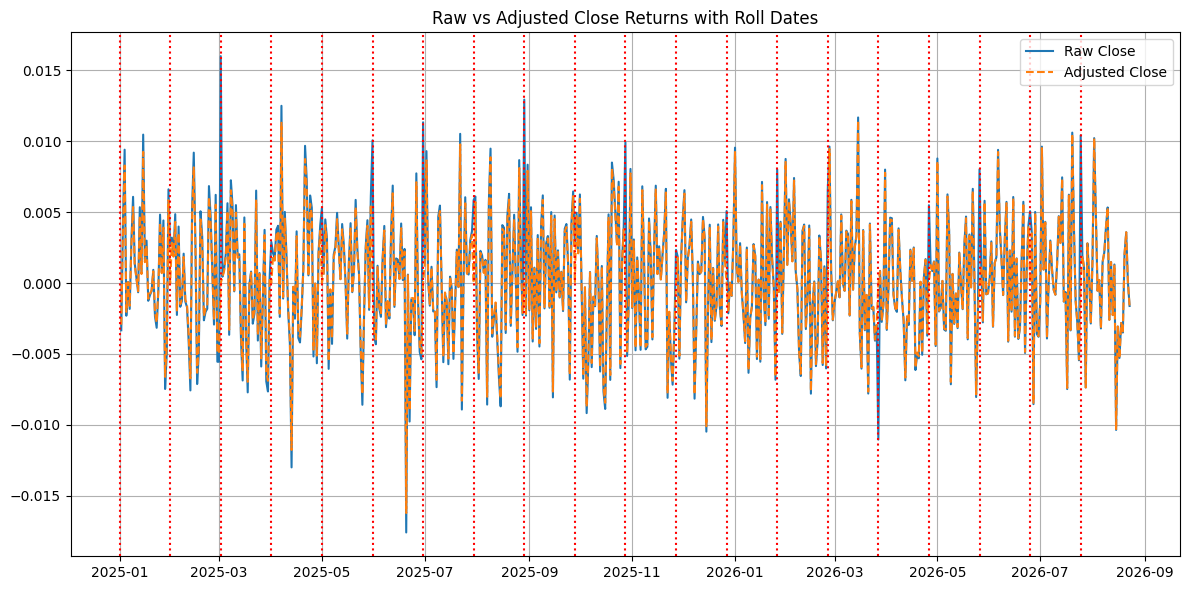

In [7]:
# Identify roll dates (i.e., where contract_id changes)
roll_dates = synthetic_df['contract_id'].ne(synthetic_df['contract_id'].shift()).loc[lambda x: x].index

plt.figure(figsize=(12, 6))
plt.plot(synthetic_df['close'].pct_change(), label='Raw Close')
plt.plot(adjusted_df['close_adj'].pct_change(), label='Adjusted Close', linestyle='--')

# Add vertical lines at roll dates
for roll_date in roll_dates:
    plt.axvline(roll_date, color='red', linestyle=':',)

plt.title("Raw vs Adjusted Close Returns with Roll Dates")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.3 NON-NEGATIVE ROLLED PRICE SERIES

In [8]:
from AFML_book_scripts import compute_non_negative_rolled_price_index

synthetic_df = generate_synthetic_futures_data()
rolled_df = compute_non_negative_rolled_price_index(synthetic_df)
rolled_df[['close', 'close_adj', 'Returns', 'Price_Index']]


,close,close_adj,Returns,Price_Index
date,,,,
2025-01-01,100.527138,117.654909,NaN,NaN
2025-01-02,101.514546,118.642318,0.009822,1.009822
2025-01-03,101.663857,118.791628,0.001471,1.011308
2025-01-04,101.760386,118.888157,0.000949,1.012268
2025-01-05,101.196882,118.324653,-0.005538,1.006662
...,...,...,...,...
2026-08-19,98.649284,98.649284,0.005093,0.830745
2026-08-20,97.388929,97.388929,-0.012776,0.820131
2026-08-21,98.392326,98.392326,0.010303,0.828581


### 2.4 SYMMETRIC CUSUM FILTER

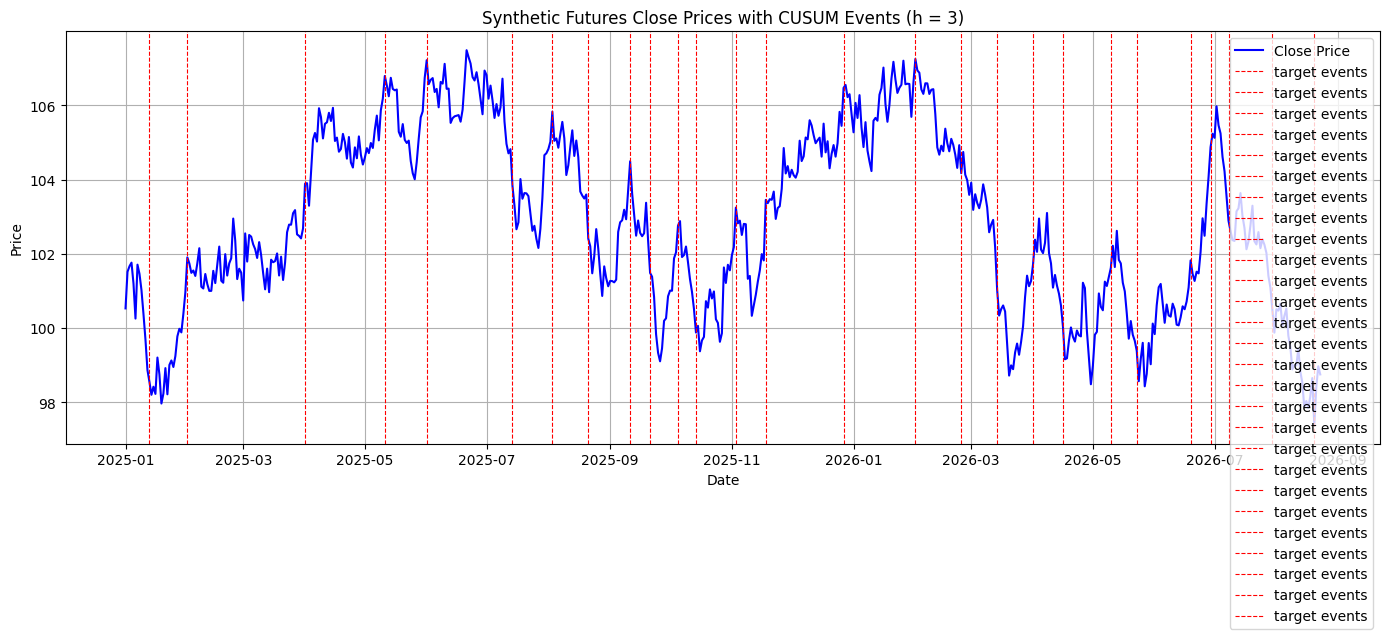

In [9]:
from AFML_book_scripts import get_CUSUM_events

h = 3
events = get_CUSUM_events(synthetic_df.close,h)

plt.figure(figsize=(14, 6))
plt.plot(synthetic_df['close'], label='Close Price', color='blue')

# Add vertical lines for events
for event in events:
    plt.axvline(event, color='red', linestyle='--', linewidth=0.8, label = 'target events')

plt.title(f"Synthetic Futures Close Prices with CUSUM Events (h = {h})")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.EXERCISES

#### EXERCISE 2.1

On a series of E-mini S&P 500 futures tick data:

1. Form tick, volume, and dollar bars. Use the ETF trick to deal with the roll.
2. Count the number of bars produced by tick, volume, and dollar bars on a
weekly basis. Plot a time series of that bar count. What bar type produces
the most stable weekly count? Why?
3. Compute the serial correlation of returns for the three bar types. What bar
method has the lowest serial correlation?
4. Partition the bar series into monthly subsets. Compute the variance of returns
for every subset of every bar type. Compute the variance of those variances.
What method exhibits the smallest variance of variances?
5. Apply the Jarque-Bera normality test on returns from the three bar types.
What method achieves the lowest test statistic?

First, unfortunately I could not find ES futures data as per contract data (front, month+1, +2...,). I found futures data for the SP500 which are presumably already roll-adjusted.

We can first check this assumption

##### Checking: is data already roll-adjusted?

In [10]:
print(os.listdir('../data'))
data = pd.read_csv('../data/SP_futures_tick_data.csv')
data.shape

['SP_futures_tick_data.csv']


(13802502, 4)

The data frame is huge hence I will only select a subset of, say, five years

In [11]:
#have a look at the data
print(data.head())
print(data.columns)

         date          time   price  volume
0  01/03/2000  08:30:34.000  1496.4       0
1  01/03/2000  08:30:36.000  1496.0       0
2  01/03/2000  08:30:37.000  1495.5       0
3  01/03/2000  08:30:46.000  1495.0       0
4  01/03/2000  08:30:53.000  1495.5       0
Index(['date', 'time', 'price', 'volume'], dtype='object')


In [12]:
print(f"data starts at {data.date.iloc[0]} and ends at {data.date.iloc[-1]}")
#select only data between 2014 and 2018
#combine 'date' and 'time' strings into one column
datetime_str = data['date'] + ' ' + data['time']
# Use dayfirst=True if your dates are day/month/year format
data['datetime'] = pd.to_datetime(datetime_str, errors='coerce')


data starts at 01/03/2000 and ends at 12/31/2019


In [13]:
#after 2013
data = data[data.datetime.dt.year >= 2014]
#before 2019
data = data[data.datetime.dt.year <= 2018]
#fiannly drop date and time 
data = data.drop(['date','time'],axis=1)
print(f'Now, data starts at {data.datetime.iloc[0]} and ends at {data.datetime.iloc[-1]}')
data = data.reset_index()

Now, data starts at 2014-01-02 05:00:00.028000 and ends at 2018-12-31 15:49:46.582000


Now, let's check if the roll is pre-made

In [14]:
#take unique month like 06-2016 ... 06-2017 are unique
data['date_only'] = data['datetime'].dt.date
data['month'] = data['datetime'].dt.to_period('M')  
data = data.sort_values('datetime')
limit = 3

roll_candidates = []

#iterate over each unique month to check whihc day on that month has the most high price jumps
for month in data['month'].unique():

    month_data = data[data['month'] == month].copy()
    month_data['price_change'] = month_data['price'].diff()
    std = month_data['price_change'].std()

    #flag jumps: abs(change) > limit * std
    month_data['is_jump'] = month_data['price_change'].abs() > (limit * std)

    #count jumps per day
    jumps_per_day = month_data.groupby('date_only')['is_jump'].sum()

    #find the day with the highest jump count
    if not jumps_per_day.empty:
        max_jump_day = jumps_per_day.idxmax()
        max_jump_count = jumps_per_day.max()
        roll_candidates.append((str(month), max_jump_day, max_jump_count))

#result DataFrame
roll_df = pd.DataFrame(roll_candidates, columns=['Month', 'Max_Jump_Day', 'Jump_Count'])
#get just the day of the month when the max jump occurred to have a ditribution
roll_df['Max_Jump_Day_Of_Month'] = pd.to_datetime(roll_df['Max_Jump_Day']).dt.day
roll_df.head()

,Month,Max_Jump_Day,Jump_Count,Max_Jump_Day_Of_Month
0,2014-01,2014-01-29,86,29
1,2014-02,2014-02-03,54,3
2,2014-03,2014-03-03,23,3
3,2014-04,2014-04-15,55,15
4,2014-05,2014-05-07,45,7


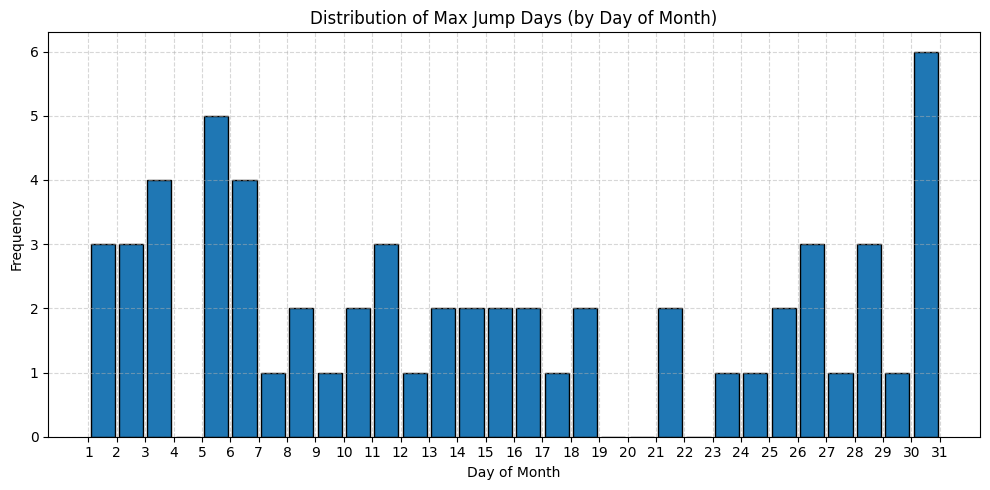

In [15]:
#histogram
plt.figure(figsize=(10, 5))
roll_df['Max_Jump_Day_Of_Month'].plot(
    kind='hist',
    bins=range(1, 32),  # Days 1 to 31
    rwidth=0.85,
    edgecolor='black'
)

plt.title('Distribution of Max Jump Days (by Day of Month)')
plt.xlabel('Day of Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 32))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


There is no a clear day with big price jumps, we can conclude that the assumption that the data have already been adjusted for rolling is true. 

We can finally start the exercise :)

##### Exercise 2.1.a

In [ ]:
data.head()
#remove the index column (index of the starting full df)
data = data.drop('index',axis=1)

,index,price,volume,datetime,date_only,month
0,13275480,1837.9,1,2014-01-02 05:00:00.028,2014-01-02,2014-01
1,13275481,1837.9,3,2014-01-02 05:00:00.028,2014-01-02,2014-01
2,13275482,1837.9,1,2014-01-02 05:00:00.028,2014-01-02,2014-01
3,13275483,1837.9,2,2014-01-02 05:00:00.028,2014-01-02,2014-01
4,13275484,1837.9,1,2014-01-02 05:00:00.028,2014-01-02,2014-01


In [21]:
#calling my functions for bar calculations

sys.path.append('../scripts')
from AFML_my_scripts import TickBarsDf,VolumeBarsDf, VolumeBarsDfVectorized, DollarBarsDfVectorized

tick_df = TickBarsDf(data,100)
volume_df = VolumeBarsDfVectorized(data,120)
dollar_df = DollarBarsDfVectorized(data,250000)

print("Let's make sure the fd have more or less the same number of bar for a better comparison")
print(f'len tick df {tick_df.shape[0]}, len volume df {volume_df.shape[0]}, len dollar df {dollar_df.shape[0]}')

Let's make sure the fd have more or less the same number of bar for a better comparison
len tick df 5095, len volume df 5198, len dollar df 5164


In [ ]:
tick_df['weeks'] = tick_df.end_date.dt.to_period('W').astype(str)
volume_df['weeks'] = volume_df.end_date.dt.to_period('W').astype(str)
dollar_df['weeks'] = dollar_df.end_date.dt.to_period('W').astype(str)

tick_df_bars_per_week = tick_df.groupby('weeks').size()
volume_df_bars_per_week = volume_df.groupby('weeks').size()
dollar_df_bars_per_week = dollar_df.groupby('weeks').size()

In [32]:
tick_df_bars_per_week.index

Index(['2013-12-30/2014-01-05', '2014-01-06/2014-01-12',
       '2014-01-13/2014-01-19', '2014-01-20/2014-01-26',
       '2014-01-27/2014-02-02', '2014-02-03/2014-02-09',
       '2014-02-10/2014-02-16', '2014-02-17/2014-02-23',
       '2014-02-24/2014-03-02', '2014-03-03/2014-03-09',
       ...
       '2018-10-29/2018-11-04', '2018-11-05/2018-11-11',
       '2018-11-12/2018-11-18', '2018-11-19/2018-11-25',
       '2018-11-26/2018-12-02', '2018-12-03/2018-12-09',
       '2018-12-10/2018-12-16', '2018-12-17/2018-12-23',
       '2018-12-24/2018-12-30', '2018-12-31/2019-01-06'],
      dtype='object', name='weeks', length=262)

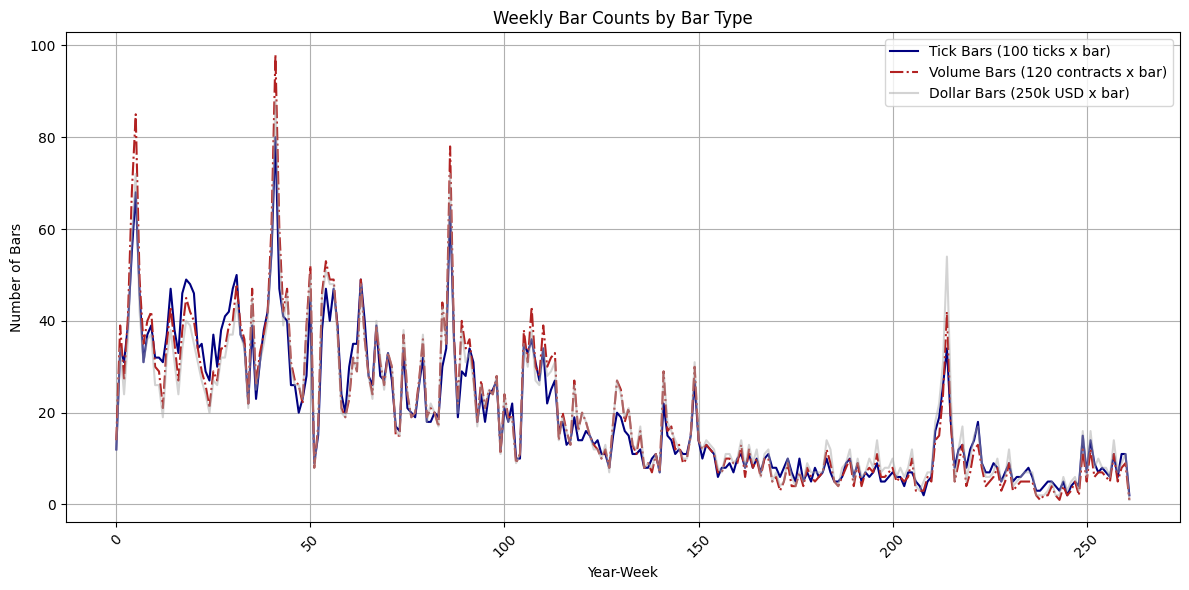

In [40]:
plt.figure(figsize=(12,6))

plt.plot(tick_df_bars_per_week.values, label = 'Tick Bars (100 ticks x bar)', color = 'navy')
plt.plot(volume_df_bars_per_week.values, label = 'Volume Bars (120 contracts x bar)', color = 'firebrick', linestyle = '-.')
plt.plot(dollar_df_bars_per_week.values, label = 'Dollar Bars (250k USD x bar)', color = 'darkgray', alpha = 0.5)

plt.xticks(rotation=45)
plt.xlabel('Year-Week')
plt.ylabel('Number of Bars')
plt.title('Weekly Bar Counts by Bar Type')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### EXERCISE 2.2